# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id	id used in the screenshot folder to identify this record
* start	start of this trade
* timeframe	in the format 2D,D,H12,H8
* entry	price
* outcome	S=success;F=failure;B=breakeven
* ext_outcome. S=success;F=failure;B=breakeven
* RSI bounces. number of RSI bounces ocurring in the trend before entry
* No of candles. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI. Was the entry candle on RSI?
* length of trend. lenght of the preceding trend in number of candles. The valley before the continuation is not included in the count
* previous swings. Number of swings from the entry and counting the rebound before the entry (see screenshot below)
* space interswings. Comma separated numbers representing the number of candles between swings from the most recent to the oldest
* length in pips. From the beginning of the trade to the entry price in number of pips
strong trend	TRUE of the preceding trend was strong
* trend angle. Measured with Oanda after hitting the auto scale button+lock scalde button and the end of the trend line is the IC+1 when it touches the entry price
* bounce length. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* bounce pips. Length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also)
* inn_bounce. Number of candles of the inner bounce (see screenshots below)
indecission	Number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce
* retraced.	Only relevant for outcome=F, how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed last time that the price was below/above this level assuming that a possible counter could happen
* entry_aligned. Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not
* trend_bounces. Discrete quantitative variable representing the number of bounces at the trend

## Dependencies

In [1956]:
import pandas as pd
import numpy as np
import pdb
import re
import math
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [1957]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.tsv',sep="\t",na_values=["n.a.","n.a"])

contDF.shape

(453, 27)

And some information about contDF:

In [1958]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 27 columns):
id                         453 non-null object
start                      453 non-null object
type                       453 non-null object
timeframe                  453 non-null object
entry                      453 non-null float64
outcome                    453 non-null object
RSI bounces                453 non-null int64
bounce length              345 non-null object
bounce (pips)              453 non-null int64
inn_bounce                 453 non-null int64
indecission                453 non-null int64
entry on RSI               453 non-null bool
length of trend (-1)       453 non-null int64
length in pips (-1)        453 non-null int64
last time                  453 non-null object
entry_aligned              453 non-null int64
retraced                   106 non-null float64
Candle +1 against trade    453 non-null object
trend_bounces              452 non-null float64
is_sr_do

* Conversion to right types<br>
Let's convert now the `start` and `last time` variables to DateTime

In [1959]:
contDF['start']= pd.to_datetime(contDF['start'])
contDF['last time']= pd.to_datetime(contDF['last time'])

## Cleaning the n.a. values
The following predictors have n.a. values and the strategy I will follow will depend on each case:

* No of candles (will replace the n.a. by 0)

In [1960]:
if "No of candles" in contDF: contDF["No of candles"].fillna(0, inplace=True)

* Bounce length (will replace the n.a. by 0)

In [1961]:
contDF["bounce length"].fillna(0, inplace=True)

* Length of trend (-1) (will replace the n.a. by 0)

In [1962]:
contDF["length of trend (-1)"].fillna(0, inplace=True)

* Length in pips (-1) (will replace the n.a. by 0)

In [1963]:
contDF["length in pips (-1)"].fillna(0, inplace=True)

## Normalize
Let's normalize all variables dealing with pips.

In [1964]:
def normalize(x, variable_name):
    '''
    Function that will calculate the number of pips per hour
    
    Parameters
    ----------
    variable: str
              Variable name that will be normalized
    '''
    
    return round(x[variable_name]/48,2)
    
    if x['timeframe']=='2D':
        return round(x[variable_name]/48,1)
    elif x['timeframe']=='D':
        return round(x[variable_name]/24,1)
    elif x['timeframe']=='H12':
        return round(x[variable_name]/12,1)
    elif x['timeframe']=='H10':
        return round(x[variable_name]/10,1)
    elif x['timeframe']=='H8':
        return round(x[variable_name]/8,1)
    elif x['timeframe']=='H6':
        return round(x[variable_name]/6,1)
    else:
        raise("Error")
    
    

In [1965]:
contDF['norm_length_pips']=contDF.apply(normalize,axis=1, variable_name='length in pips (-1)')
contDF['norm_bounce_pips']=contDF.apply(normalize,axis=1, variable_name='bounce (pips)')
contDF['norm_retraced']=contDF.apply(normalize,axis=1, variable_name='retraced')

## Transforming

In [1966]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

if "ext_outcome" in contDF: contDF['ext_outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='ext_outcome')
contDF['outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome')
contDF['entry on RSI']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI')
if "strong_trend" in contDF: contDF['strong trend']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='strong trend')

## Selecting the desired timeframe

contDF=contDF[contDF.timeframe == 'H6']

## Checking the redudant trades
Let's sort the trades by date to check if there are reduntant trades:

sortedDF=contDF.sort_values(by='start')
print(sortedDF)

sortedDF.to_csv('/Users/ernesto/Downloads/sorted_contDF.tsv',sep='\t')

## Calculating extended outcome based on the norm_retraced variable
Trades having retraced by less that a cut off number of pips will be considered Successful

In [1967]:
def calc_extoutcome(row,cutoff=20):
    if not math.isnan(row['norm_retraced']):
        if row['norm_retraced']<=cutoff:
            return int(1)
        else:
            return int(0)
    else:
        return int(row['outcome'])
        
            

In [1968]:
contDF['ext_outcome']=contDF.apply(calc_extoutcome,axis=1)

## Selecting the trades having entry_aligned=1

In [1969]:
contDF=contDF.loc[contDF['entry_aligned']==1]

## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

outcome_ix=5
outcome_lab="outcome"
contDF.iloc[:,outcome_ix].value_counts()

In [1970]:
outcome_ix=30
outcome_lab="ext_outcome"
contDF.iloc[:,outcome_ix].value_counts()

1    205
0     59
Name: ext_outcome, dtype: int64

### last time 
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.

In [1971]:
contDF['diff']=(contDF['start']-contDF['last time'])

In [1972]:
contDF['diff']=contDF['diff'].apply(lambda x: x.days)

Now, let's examine the distribution of this newly created `diff` variable in the 2 `outcome` categories

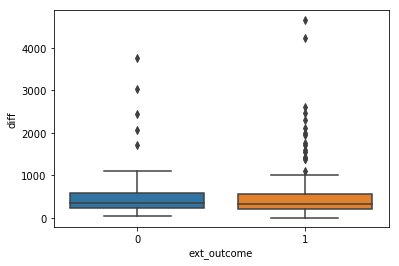

In [1973]:
ax = sns.boxplot(x=outcome_lab, y="diff", data=contDF)

* Mean for each category

In [1974]:
contDF.groupby(outcome_lab).agg({'diff': 'mean'})

,diff
ext_outcome,
0,585.881356
1,501.882927


* Median for each category

In [1975]:
contDF.groupby(outcome_lab).agg({'diff': 'median'})

,diff
ext_outcome,
0,341
1,336


* Histogram

In [1976]:
import matplotlib.pyplot as plt

succ=contDF.loc[contDF[outcome_lab]==1]['diff']
fail=contDF.loc[contDF[outcome_lab]==0]['diff']

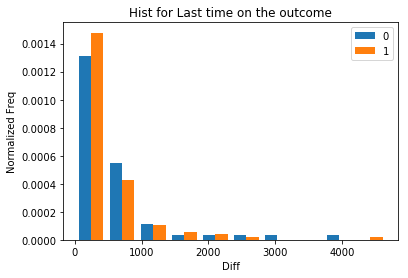

In [1977]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Diff')
plt.ylabel('Normalized Freq')
plt.title('Hist for Last time on the outcome')

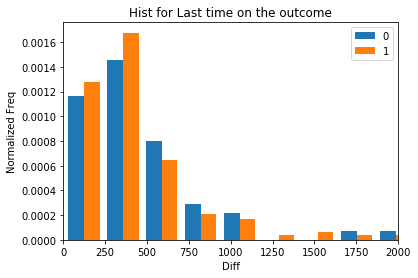

In [1978]:
plt.xlim(0,2000)

plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Diff')
plt.ylabel('Normalized Freq')
plt.title('Hist for Last time on the outcome')

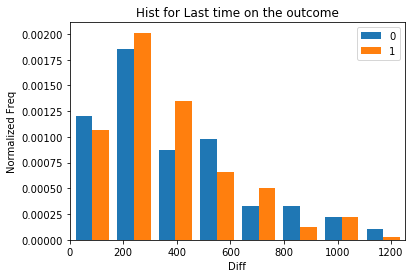

In [1979]:
plt.xlim(0,1250)

plt.hist([fail,succ], bins = 30, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Diff')
plt.ylabel('Normalized Freq')
plt.title('Hist for Last time on the outcome')

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

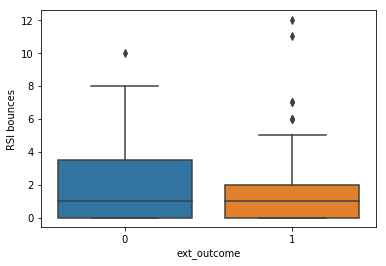

In [1980]:
ax = sns.boxplot(x=outcome_lab, y="RSI bounces", data=contDF)

* Mean for each category

In [1981]:
contDF.groupby(outcome_lab).agg({'RSI bounces': 'mean'})

,RSI bounces
ext_outcome,
0,2.135593
1,1.639024


* Median for each category

In [1982]:
medianBounce=contDF.groupby(outcome_lab).agg({'RSI bounces': 'median'})
print(medianBounce)

             RSI bounces
ext_outcome             
0                      1
1                      1


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

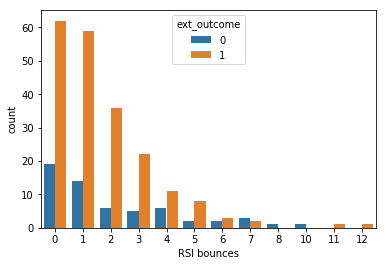

In [1983]:
ax = sns.countplot(x="RSI bounces",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

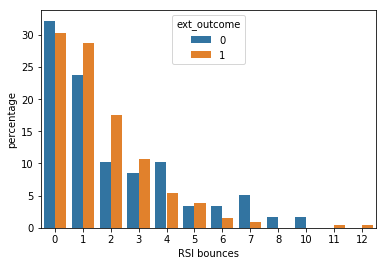

In [1984]:
contDF_counts = (contDF.groupby([outcome_lab])['RSI bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces'))

p = sns.barplot(x="RSI bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [1985]:
import matplotlib.pyplot as plt

succ=contDF.loc[contDF[outcome_lab]==1]['RSI bounces']
fail=contDF.loc[contDF[outcome_lab]==0]['RSI bounces']

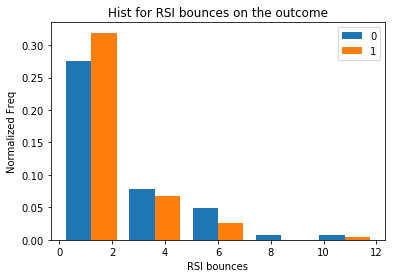

In [1986]:
plt.hist([fail,succ], bins = 5, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('RSI bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for RSI bounces on the outcome')

* Conclusion<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces

### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>

As an initial exploration I will create a boxplot displaying the data:

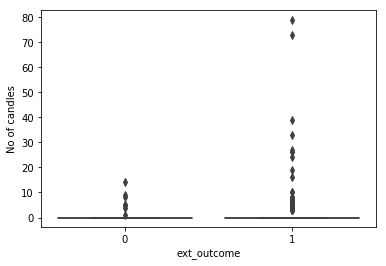

In [1987]:
if "No of candles" in contDF: ax = sns.boxplot(x=outcome_lab, y="No of candles", data=contDF)

* Mean for each category

In [1988]:
if "No of candles" in contDF: contDF.groupby(outcome_lab).agg({'No of candles': 'mean'})

* Median for each category

In [1989]:
if "No of candles" in contDF: contDF.groupby(outcome_lab).agg({'No of candles': 'median'})

Let's analyze the distribution with a histogram

In [1990]:
if "No of candles" in contDF: succ=contDF.loc[contDF[outcome_lab]==1]['No of candles']
if "No of candles" in contDF: fail=contDF.loc[contDF[outcome_lab]==0]['No of candles']

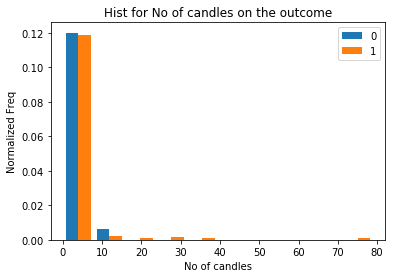

In [1991]:
if "No of candles" in contDF: plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

if "No of candles" in contDF: plt.legend()
if "No of candles" in contDF: plt.xlabel('No of candles')
if "No of candles" in contDF: plt.ylabel('Normalized Freq')
if "No of candles" in contDF: plt.title('Hist for No of candles on the outcome')

This distribution is right skewed, let's cap the X axis values:

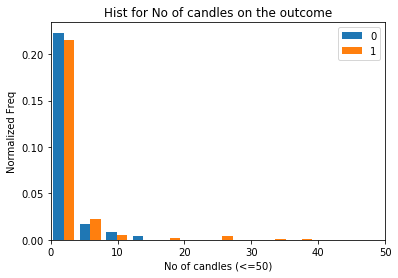

In [1992]:
if "No of candles" in contDF: plt.xlim(0,50)
if "No of candles" in contDF: plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

if "No of candles" in contDF: plt.legend()
if "No of candles" in contDF: plt.xlabel('No of candles (<=50)')
if "No of candles" in contDF: plt.ylabel('Normalized Freq')
if "No of candles" in contDF: plt.title('Hist for No of candles on the outcome')

### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [1993]:
contDF['entry on RSI'].value_counts()

0    209
1     55
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1994]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI    0   1  All
ext_outcome               
0              51   8   59
1             158  47  205
All           209  55  264


It's is easier to visualize the relationship if we calculate the percentages:

In [1995]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI           0           1         All
ext_outcome                                     
0              24.401914   14.545455   22.348485
1              75.598086   85.454545   77.651515
All           100.000000  100.000000  100.000000


### length of trend (-1)
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

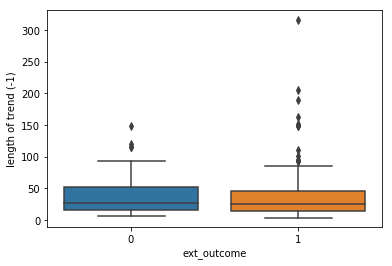

In [1996]:
ax = sns.boxplot(x=outcome_lab, y="length of trend (-1)", data=contDF)

Let's analyze the distribution with a histogram

In [1997]:
succ=contDF.loc[contDF[outcome_lab]==1]['length of trend (-1)']
fail=contDF.loc[contDF[outcome_lab]==0]['length of trend (-1)']

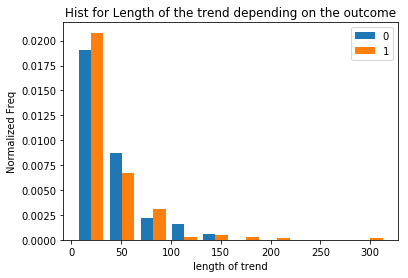

In [1998]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

This distribution is right skewed, let's cap the X axis values:

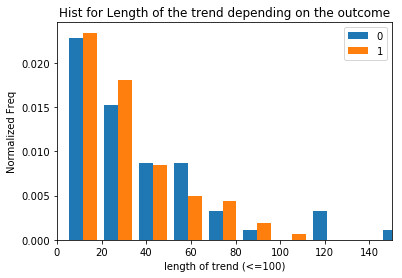

In [1999]:
plt.xlim(0,150)
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend (<=100)')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

* Mean for each category

In [2000]:
contDF.groupby(outcome_lab).agg({'length of trend (-1)': 'mean'})

,length of trend (-1)
ext_outcome,
0,38.576271
1,37.282927


* Median for each category

In [2001]:
contDF.groupby(outcome_lab).agg({'length of trend (-1)': 'median'})

,length of trend (-1)
ext_outcome,
0,27
1,25


### length_bounce_perc
This variable represents what % of the total length of the trend represents the inn_bounce

In [2002]:
contDF['length_bounce_perc']=contDF['inn_bounce'].astype(int)*100/contDF['length of trend (-1)'].astype(int)

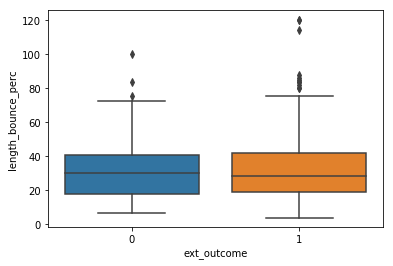

In [2003]:
ax = sns.boxplot(x=outcome_lab, y="length_bounce_perc", data=contDF)

* Mean for each category

In [2004]:
contDF.groupby(outcome_lab).agg({'length_bounce_perc': 'mean'})

,length_bounce_perc
ext_outcome,
0,32.650194
1,33.213455


* Median for each category

In [2005]:
contDF.groupby(outcome_lab).agg({'length_bounce_perc': 'median'})

,length_bounce_perc
ext_outcome,
0,30.000000
1,28.571429


Let's analyze the distribution with a histogram

In [2006]:
succ=contDF.loc[contDF[outcome_lab]==1]['length_bounce_perc']
fail=contDF.loc[contDF[outcome_lab]==0]['length_bounce_perc']

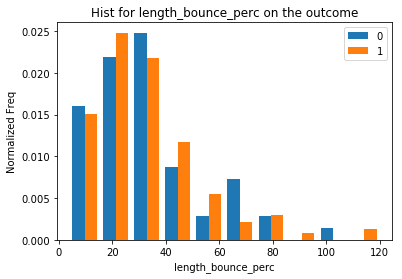

In [2007]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length_bounce_perc')
plt.ylabel('Normalized Freq')
plt.title('Hist for length_bounce_perc on the outcome')

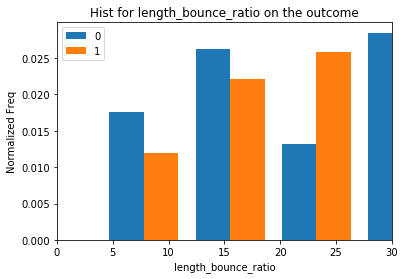

In [2008]:
plt.xlim(0,30)

plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length_bounce_ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for length_bounce_ratio on the outcome')

### Length in pips

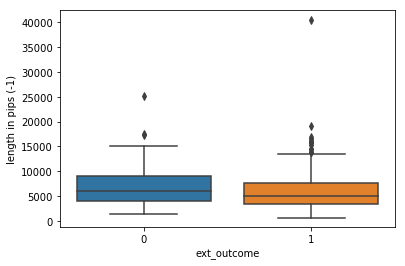

In [2009]:
ax = sns.boxplot(x=outcome_lab, y="length in pips (-1)", data=contDF)

Let's analyze the distribution with a histogram

In [2010]:
succ=contDF.loc[contDF[outcome_lab]==1]['length in pips (-1)']
fail=contDF.loc[contDF[outcome_lab]==0]['length in pips (-1)']

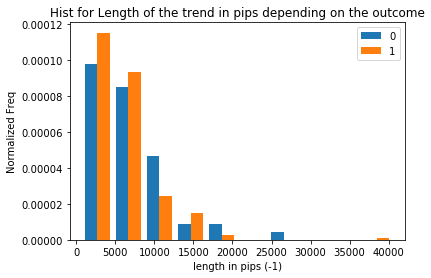

In [2011]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length in pips (-1)')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend in pips depending on the outcome')

This distribution is right skewed, let's cap the X axis values:

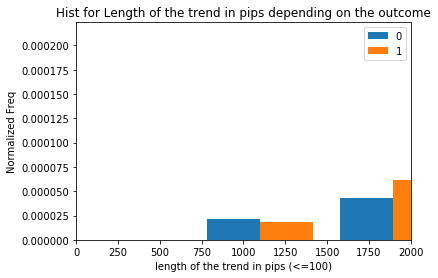

In [2012]:
plt.xlim(0,2000)
plt.hist([fail,succ], bins = 50, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of the trend in pips (<=100)')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend in pips depending on the outcome')

* Mean for each category

In [2013]:
contDF.groupby(outcome_lab).agg({'length in pips (-1)': 'mean'})

,length in pips (-1)
ext_outcome,
0,7156.457627
1,6135.663415


* Median for each category

In [2014]:
contDF.groupby(outcome_lab).agg({'length in pips (-1)': 'median'})

,length in pips (-1)
ext_outcome,
0,6003
1,5118


### Pips_ratio
This variable contains the ratio between 'length in pips'/'length of trend (-1)'

In [2015]:
contDF['pips_ratio']=contDF['length in pips (-1)'].astype(int)/contDF['length of trend (-1)'].astype(int)

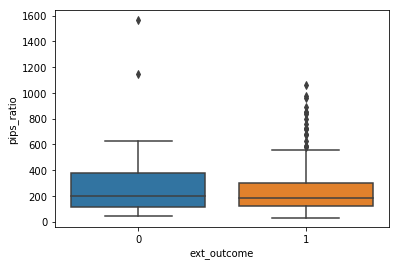

In [2016]:
ax = sns.boxplot(x=outcome_lab, y="pips_ratio", data=contDF)

* Mean for each category

In [2017]:
contDF.groupby(outcome_lab).agg({'pips_ratio': 'mean'})

,pips_ratio
ext_outcome,
0,284.642676
1,248.177413


* Median for each category

In [2018]:
contDF.groupby(outcome_lab).agg({'pips_ratio': 'median'})

,pips_ratio
ext_outcome,
0,201.454545
1,185.142857


Let's analyze the distribution with a histogram

In [2019]:
succ=contDF.loc[contDF[outcome_lab]==1]['pips_ratio']
fail=contDF.loc[contDF[outcome_lab]==0]['pips_ratio']

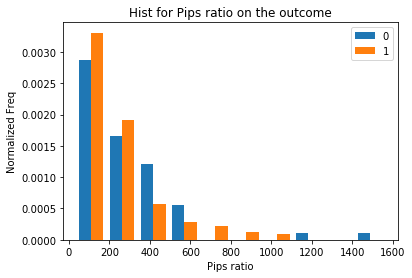

In [2020]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

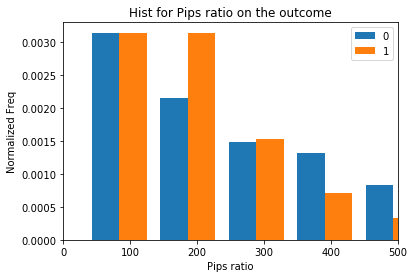

In [2021]:
plt.xlim(0,500)

plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

### Pips_ratio normalized

In [2022]:
contDF['pips_ratio_norm']=contDF['norm_length_pips'].astype(int)/contDF['length of trend (-1)'].astype(int)

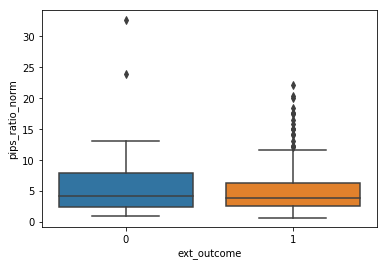

In [2023]:
ax = sns.boxplot(x=outcome_lab, y="pips_ratio_norm", data=contDF)

* Mean for each category

In [2024]:
contDF.groupby(outcome_lab).agg({'pips_ratio_norm': 'mean'})

,pips_ratio_norm
ext_outcome,
0,5.907768
1,5.146518


* Median for each category

In [2025]:
contDF.groupby(outcome_lab).agg({'pips_ratio_norm': 'median'})

,pips_ratio_norm
ext_outcome,
0,4.181818
1,3.854839


Let's analyze the distribution with a histogram

In [2026]:
succ=contDF.loc[contDF[outcome_lab]==1]['pips_ratio_norm']
fail=contDF.loc[contDF[outcome_lab]==0]['pips_ratio_norm']

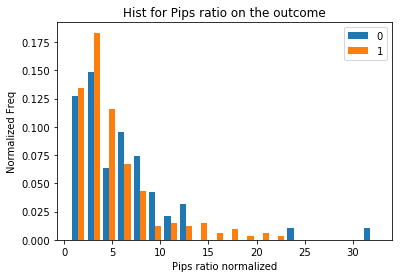

In [2027]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio normalized')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

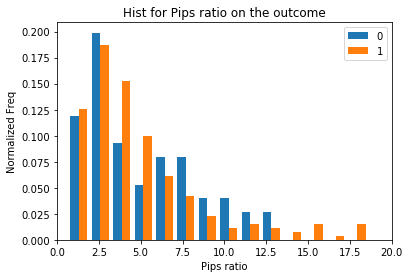

In [2028]:
plt.xlim(0,20)

plt.hist([fail,succ], bins = 25, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

### inn_bounce
Integer variable representing the number of candles of the inner bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

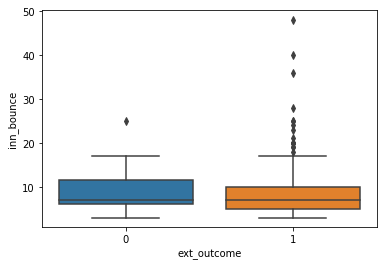

In [2029]:
ax = sns.boxplot(x=outcome_lab, y="inn_bounce", data=contDF)

* Mean for each category

In [2030]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'mean'})

,inn_bounce
ext_outcome,
0,8.542373
1,8.643902


* Median for each category

In [2031]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'median'})

,inn_bounce
ext_outcome,
0,7
1,7


* Barplot

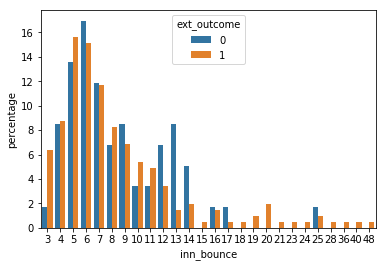

In [2032]:
contDF_counts = (contDF.groupby([outcome_lab])['inn_bounce']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('inn_bounce'))

p = sns.barplot(x="inn_bounce", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [2033]:
succ=contDF.loc[contDF[outcome_lab]==1]['inn_bounce']
fail=contDF.loc[contDF[outcome_lab]==0]['inn_bounce']

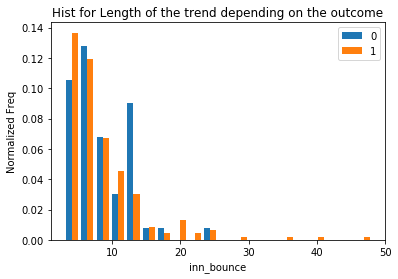

In [2034]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('inn_bounce')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

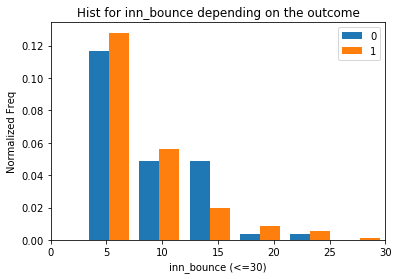

In [2035]:
plt.xlim(0,30)
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('inn_bounce (<=30)')
plt.ylabel('Normalized Freq')
plt.title('Hist for inn_bounce depending on the outcome')

### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [2036]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [2037]:
contDF['sum_bounces']=contDF['bounce length'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

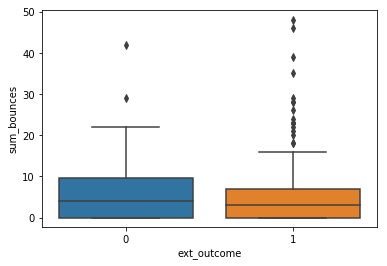

In [2038]:
ax = sns.boxplot(x=outcome_lab, y="sum_bounces", data=contDF)

* Mean for each category

In [2039]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'mean'})

,sum_bounces
ext_outcome,
0,6.559322
1,5.848780


* Median for each category

In [2040]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'median'})

,sum_bounces
ext_outcome,
0,4
1,3


* Histogram

In [2041]:
succ=contDF.loc[contDF[outcome_lab]==1]['sum_bounces']
fail=contDF.loc[contDF[outcome_lab]==0]['sum_bounces']

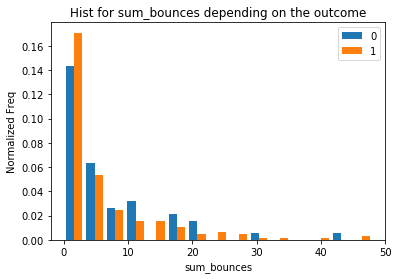

In [2042]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for sum_bounces depending on the outcome')

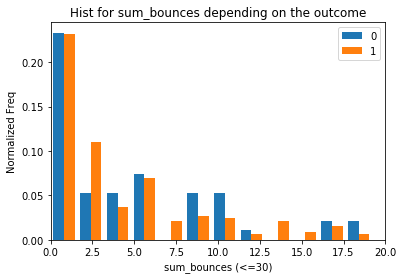

In [2043]:
plt.xlim(0,20)
plt.hist([fail,succ], bins = 30, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces (<=30)')
plt.ylabel('Normalized Freq')
plt.title('Hist for sum_bounces depending on the outcome')

### bounce (pips)
This quantitative variable represents the length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also).  Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

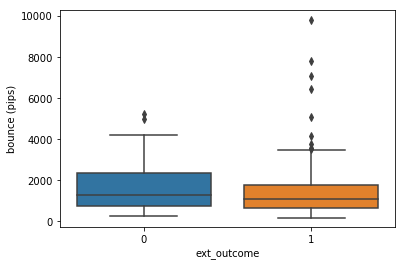

In [2044]:
ax = sns.boxplot(x=outcome_lab, y="bounce (pips)", data=contDF)

* Mean for each category

In [2045]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'mean'})

,bounce (pips)
ext_outcome,
0,1689.423729
1,1414.780488


* Median for each category

In [2046]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'median'})

,bounce (pips)
ext_outcome,
0,1295
1,1080


* Histogram

In [2047]:
succ=contDF.loc[contDF[outcome_lab]==1]['bounce (pips)']
fail=contDF.loc[contDF[outcome_lab]==0]['bounce (pips)']

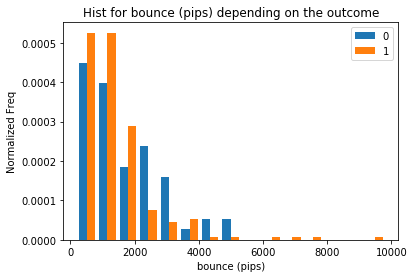

In [2048]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips)')
plt.ylabel('Normalized Freq')
plt.title('Hist for bounce (pips) depending on the outcome')

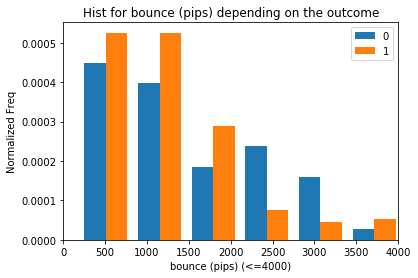

In [2049]:
plt.xlim(0,4000)
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips) (<=4000)')
plt.ylabel('Normalized Freq')
plt.title('Hist for bounce (pips) depending on the outcome')

### norm_bounce_pips

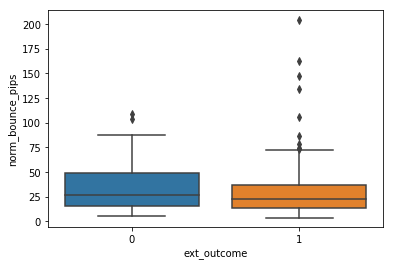

In [2050]:
ax = sns.boxplot(x=outcome_lab, y="norm_bounce_pips", data=contDF)

* Mean for each category

In [2051]:
contDF.groupby(outcome_lab).agg({'norm_bounce_pips': 'mean'})

,norm_bounce_pips
ext_outcome,
0,35.195932
1,29.474927


* Median for each category

In [2052]:
contDF.groupby(outcome_lab).agg({'norm_bounce_pips': 'median'})

,norm_bounce_pips
ext_outcome,
0,26.98
1,22.50


* Histogram

In [2053]:
succ=contDF.loc[contDF[outcome_lab]==1]['norm_bounce_pips']
fail=contDF.loc[contDF[outcome_lab]==0]['norm_bounce_pips']

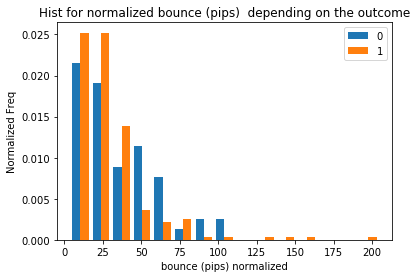

In [2054]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips) normalized')
plt.ylabel('Normalized Freq')
plt.title('Hist for normalized bounce (pips)  depending on the outcome')

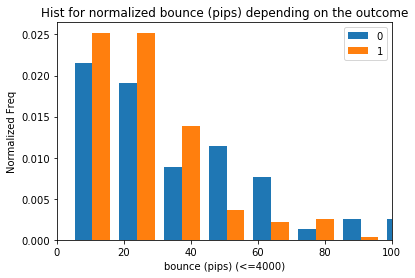

In [2055]:
plt.xlim(0,100)
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips) (<=4000)')
plt.ylabel('Normalized Freq')
plt.title('Hist for normalized bounce (pips) depending on the outcome')

### entry_aligned
Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [2056]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry_aligned'],margins=True)
print(div_class)

entry_aligned    1  All
ext_outcome            
0               59   59
1              205  205
All            264  264


It's is easier to visualize the relationship if we calculate the percentages:

In [2057]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

entry_aligned           1         All
ext_outcome                          
0               22.348485   22.348485
1               77.651515   77.651515
All            100.000000  100.000000


* Conclusion <br>
There is a clear relationship between succesful trades and `entry_aligned=1`

### Trend bounces
Discrete variable representing the number of bounces at the trend. This variable only makes sense when entry_aligned=1

In [2058]:
contDF_entryaligned=contDF[contDF.entry_aligned == 1]

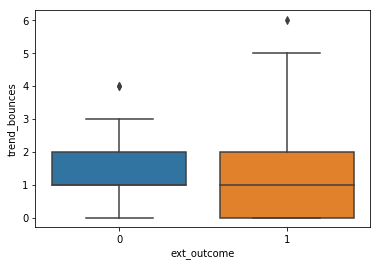

In [2059]:
ax = sns.boxplot(x=outcome_lab, y="trend_bounces", data=contDF_entryaligned)

* Mean for each category

In [2060]:
contDF_entryaligned.groupby(outcome_lab).agg({'trend_bounces': 'mean'})

,trend_bounces
ext_outcome,
0,1.237288
1,1.243902


* Median for each category

In [2061]:
medianBounce=contDF_entryaligned.groupby(outcome_lab).agg({'trend_bounces': 'median'})
print(medianBounce)

             trend_bounces
ext_outcome               
0                      1.0
1                      1.0


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

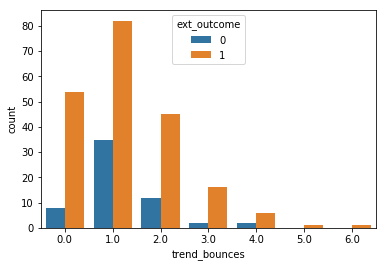

In [2062]:
ax = sns.countplot(x="trend_bounces",hue=outcome_lab, data=contDF_entryaligned)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

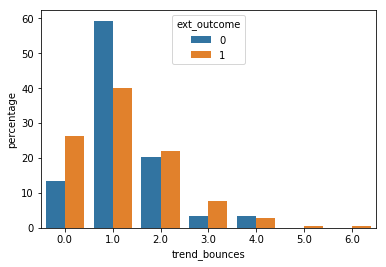

In [2063]:
contDF_counts = (contDF_entryaligned.groupby([outcome_lab])['trend_bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('trend_bounces'))

p = sns.barplot(x="trend_bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [2064]:
import matplotlib.pyplot as plt

succ=contDF_entryaligned.loc[contDF_entryaligned[outcome_lab]==1]['trend_bounces']
fail=contDF_entryaligned.loc[contDF_entryaligned[outcome_lab]==0]['trend_bounces']

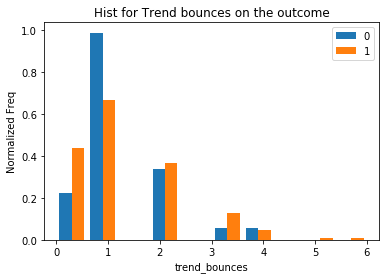

In [2065]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('trend_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for Trend bounces on the outcome')

### Indecission
Number of candles the price stays in S/R

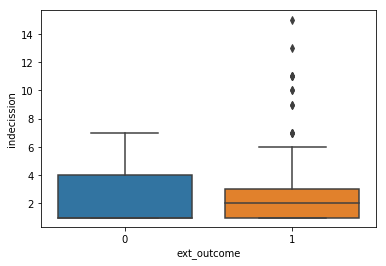

In [2066]:
ax = sns.boxplot(x=outcome_lab, y="indecission", data=contDF)

* Mean for each category

In [2067]:
contDF.groupby(outcome_lab).agg({'indecission': 'mean'})

,indecission
ext_outcome,
0,2.627119
1,2.551220


* Median for each category

In [2068]:
medianBounce=contDF.groupby(outcome_lab).agg({'indecission': 'median'})
print(medianBounce)

             indecission
ext_outcome             
0                      1
1                      2


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

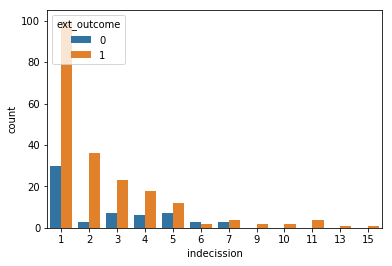

In [2069]:
ax = sns.countplot(x="indecission",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

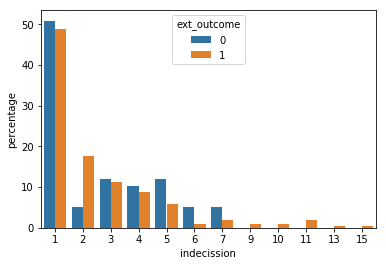

In [2070]:
contDF_counts = (contDF.groupby([outcome_lab])['indecission']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('indecission'))

p = sns.barplot(x="indecission", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [2071]:
import matplotlib.pyplot as plt

succ=contDF.loc[contDF[outcome_lab]==1]['indecission']
fail=contDF.loc[contDF[outcome_lab]==0]['indecission']

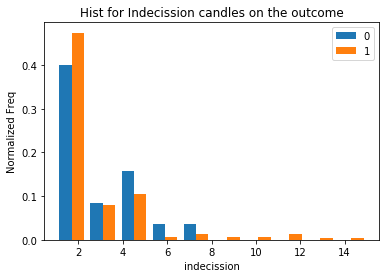

In [2072]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('indecission')
plt.ylabel('Normalized Freq')
plt.title('Hist for Indecission candles on the outcome')

### Inn_bounce/Indecisison ratio
Float variable representing the ratio between the internal bounce divided by the indecission ratio

In [2073]:
contDF['bounce_ratio']=contDF['inn_bounce']/contDF['indecission']

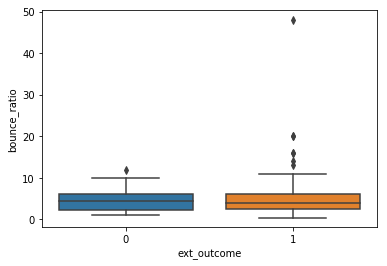

In [2074]:
ax = sns.boxplot(x=outcome_lab, y="bounce_ratio", data=contDF)

* Mean for each category

In [2075]:
contDF.groupby(outcome_lab).agg({'bounce_ratio': 'mean'})

,bounce_ratio
ext_outcome,
0,4.619855
1,4.921180


* Median for each category

In [2076]:
contDF.groupby(outcome_lab).agg({'bounce_ratio': 'median'})

,bounce_ratio
ext_outcome,
0,4.333333
1,4.000000


Let's analyze the distribution with a histogram

In [2077]:
succ=contDF.loc[contDF[outcome_lab]==1]['bounce_ratio']
fail=contDF.loc[contDF[outcome_lab]==0]['bounce_ratio']

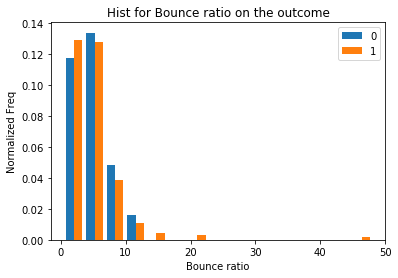

In [2078]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Bounce ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Bounce ratio on the outcome')

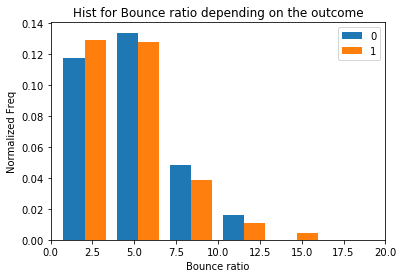

In [2079]:
plt.xlim(0,20)
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Bounce ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Bounce ratio depending on the outcome')

## Calculating points
This section will calculate a total score for each trade that will be used to predict the outcome.<br>

First, let's create a function to calculate the points

In [2080]:
def calculate_points(row,attribs):
    '''
    Function to calculate the points for a particular trade
    
    Parameters
    ----------
    row : dataframe row
    attribs : list of dicts
              The dict has the following format:
              {'attr' : 'RSI bounces',
               'cutoff' : [(0,6), (7,10), (11,100000)],
               'points' : [2,-2,-3]}
               
    Returns
    -------
    Returns a score for this trade
    
    '''
    score=0
    for a in attribs:
        value=row[a['attr']]
        cutoffs=a['cutoffs']
        points=a['points']
        if cutoffs =='bool':
            if a['rel'] == 'is_true':
                if value == True or value == 1:
                    score+=points
                if value == False  or value == 0:
                    score+=-1*points
        else:
            if len(cutoffs)!= len(points):
                raise Exception("Length of cutoffs is different to length of points")
            for i, j in zip(cutoffs, points):
                if value>=i[0] and value<=i[1]:
                    score+=j
                
    return score

# ALL
attbs=[]

attbs.append({
        'attr' : 'diff',
        'cutoffs' : [(0,700),(701,100000)],
        'points' : [1,-1]
        })
attbs.append({
        'attr' : 'RSI bounces',
        'cutoffs' : [(0,2), (3,3), (4,100000)],
        'points' : [2,-1,-2]
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 3
        })
attbs.append({
        'attr' : 'length of trend (-1)',
        'cutoffs' : [(0,10),(11,25),(26,35),(36,60),(61,10000)],
        'points' : [-1,2,1,-1,-2]
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoffs' : [(0,7),(8,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'pips_ratio_norm',
        'cutoffs' : [(0,3),(4,30)],
        'points' : [-2,2]
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoffs' : [(0,7),(8,100000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'norm_bounce_pips',
        'cutoffs' : [(0,48),(49,1000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'entry_aligned',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 6
        })
attbs.append( {
        'attr' : 'indecission',
        'cutoffs' : [(0,3),(4,5),(6,100)],
        'points' : [1,-1,-2]
        })
attbs.append( {
        'attr' : 'bounce_ratio',
        'cutoffs' : [(0,3),(4,10000)],
        'points' : [-2,2]
        })

In [2081]:
# ALL and entry_aligned=1
attbs.append({
        'attr' : 'diff',
        'cutoffs' : [(0,700),(701,100000)],
        'points' : [1,-1]
        })
attbs.append({
        'attr' : 'RSI bounces',
        'cutoffs' : [(0,0),(1,3),(4,100000)],
        'points' : [1,2,-2]
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 1
        })
attbs.append({
        'attr' : 'length of trend (-1)',
        'cutoffs' : [(0,10),(11,40),(41,50),(51,120),(121,10000)],
        'points' : [-1,2,1,-1,-2]
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoffs' : [(0,3),(4,100000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'norm_bounce_pips',
        'cutoffs' : [(0,48),(49,1000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'indecission',
        'cutoffs' : [(0,1),(1,2),(3,3),(4,1000)],
        'points' : [-1,2,-1,-2]
        })

# D
attbs=[]

attbs.append({
        'attr' : 'diff',
        'cutoffs' : [(0,300),(301,100000)],
        'points' : [2,-2]
        })
attbs.append({
        'attr' : 'RSI bounces',
        'cutoffs' : [(0,2), (3,3), (4,100000)],
        'points' : [2,-1,-2]
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 3
        })
attbs.append( {
        'attr' : 'length of trend (-1)',
        'cutoffs' : [(0,10),(11,14),(15,23),(24,50),(51,10000)],
        'points' : [-1,1,2,1,-2]
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoffs' : [(0,7),(8,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'pips_ratio',
        'cutoffs' : [(0,150),(151,220),(221,1000000000000)],
        'points' : [-2,1,2]
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoffs' : [(0,6),(7,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce (pips)',
        'cutoffs' : [(0,800),(801,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'entry_aligned',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 6
        })
attbs.append( {
        'attr' : 'indecission',
        'cutoffs' : [(0,3),(4,20)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce_ratio',
        'cutoffs' : [(0,4),(5,10000)],
        'points' : [-2,2]
        })

# H12
attbs=[]

attbs.append({
        'attr' : 'diff',
        'cutoffs' : [(0,600),(601,100000)],
        'points' : [2,-2]
        })
attbs.append({
        'attr' : 'RSI bounces',
        'cutoffs' : [(0,1),(2,2),(3,6),(7,100000)],
        'points' : [2,1,-1,-2]
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 3
        })
attbs.append( {
        'attr' : 'length of trend (-1)',
        'cutoffs' : [(0,9), (10,99),(100,1000000)],
        'points' : [-1,1,-1]
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoffs' : [(0,7),(8,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'pips_ratio',
        'cutoffs' : [(0,150),(151,1000000000000)],
        'points' : [-2,2]
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoffs' : [(0,4),(5,100000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce (pips)',
        'cutoffs' : [(0,900),(901,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'entry_aligned',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 6
        })
attbs.append( {
        'attr' : 'indecission',
        'cutoffs' : [(0,5),(6,20)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce_ratio',
        'cutoffs' : [(0,6),(7,10000)],
        'points' : [2,-2]
        })

#H6
attbs=[]

attbs.append({
        'attr' : 'diff',
        'cutoffs' : [(0,350),(351,1000000)],
        'points' : [-2,2]
        })
attbs.append({
        'attr' : 'RSI bounces',
        'cutoffs' : [(0,0),(1,3),(4,1000)],
        'points' : [-1,2,-1]
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 3
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoffs' : [(0,5),(6,1000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'pips_ratio',
        'cutoffs' : [(0,100),(101,10000)],
        'points' : [-1,1]
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoffs' : [(0,3),(4,100000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce (pips)',
        'cutoffs' : [(0,600),(601,1000000)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'entry_aligned',
        'cutoffs' : 'bool',
        'rel' : 'is_true',
        'points' : 6
        })
attbs.append( {
        'attr' : 'indecission',
        'cutoffs' : [(0,1),(2,10)],
        'points' : [2,-2]
        })
attbs.append( {
        'attr' : 'bounce_ratio',
        'cutoffs' : [(0,5),(6,1000)],
        'points' : [-2,2]
        })

Now, let's apply the calculate_points on each row of the dataframe

In [2082]:
contDF['score']=contDF.apply(calculate_points, axis=1, attribs=attbs)

Examining trades with score above the chosen cutoff but failing:

In [2083]:
print(outcome_lab)
contDF.loc[(contDF[outcome_lab]==0) & (contDF['score']>3)]

ext_outcome


,id,start,type,timeframe,entry,outcome,RSI bounces,bounce length,bounce (pips),inn_bounce,...,norm_bounce_pips,norm_retraced,ext_outcome,diff,length_bounce_perc,pips_ratio,pips_ratio_norm,sum_bounces,bounce_ratio,score
10,USD_JPY 17OCT2018H12,2018-10-17 10:00:00,short,H12,112.13700,0,1,1,590,6,...,12.29,NaN,0,281,33.333333,126.388889,2.611111,1,1.200000,21
23,USD_JPY 07MAR2007H12,2007-07-03 10:00:00,short,H12,116.22500,0,2,"5,1",1295,6,...,26.98,NaN,0,537,37.500000,336.062500,7.000000,6,6.000000,29
28,USD_JPY 04MAR2009D,2009-04-03 23:00:00,long,D,98.63100,0,1,2,1470,6,...,30.62,64.58,0,449,30.000000,487.550000,10.150000,2,6.000000,47
41,USD_CHF 24MAY2016D,2016-05-24 23:00:00,long,D,0.99243,0,0,0,485,4,...,10.10,NaN,0,143,28.571429,277.428571,5.714286,0,4.000000,35
56,USD_CHF 10SEP2013H12,2013-10-09 10:00:00,long,H12,0.93456,0,1,2,1268,13,...,26.42,NaN,0,275,72.222222,90.444444,1.833333,2,4.333333,25
105,USD_CAD 10NOV2008D,2008-07-11 23:00:00,short,D,1.17019,0,0,0,4200,6,...,87.50,NaN,0,183,75.000000,1566.625000,32.625000,0,6.000000,12
113,NZD_USD 26APR2011D,2011-04-25 23:00:00,long,D,0.80398,0,3,"3,5,3",373,4,...,7.77,44.54,0,3036,14.814815,313.333333,6.518519,11,4.000000,25
131,NZD_JPY 25SEP2018H12,2018-09-25 10:00:00,long,H12,75.11900,0,1,4,573,7,...,11.94,NaN,0,260,31.818182,118.590909,2.454545,4,7.000000,25
144,NZD_JPY 06AUG2012H12,2012-06-08 22:00:00,long,H12,64.34600,0,0,0,280,4,...,5.83,NaN,0,155,23.529412,172.176471,3.529412,0,4.000000,33
146,NZD_JPY 05NOV2010H12,2010-05-11 09:00:00,long,H12,64.35100,0,0,0,300,3,...,6.25,NaN,0,126,33.333333,387.444444,8.000000,0,3.000000,32


### Calculating cutoff score
* Mean

In [2084]:
contDF.groupby(outcome_lab).agg({'score': 'mean'})

,score
ext_outcome,
0,12.118644
1,18.960976


* Median

In [2085]:
contDF.groupby(outcome_lab).agg({'score': 'median'})

,score
ext_outcome,
0,14
1,24


* Histogram

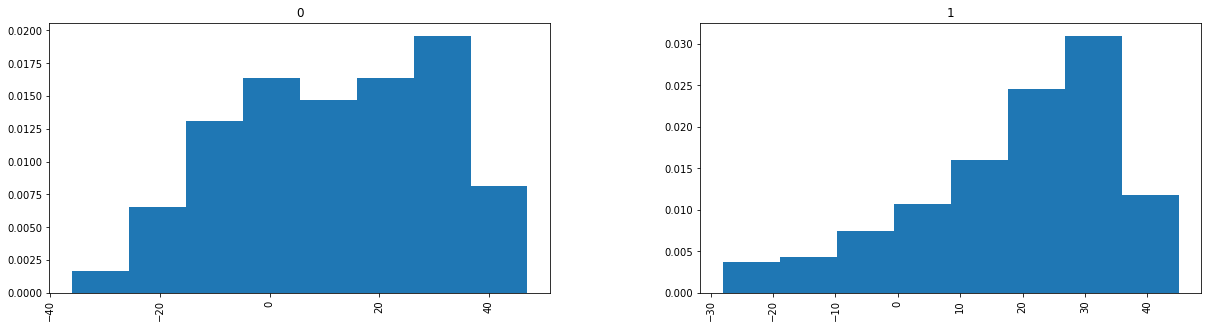

In [2086]:
axList=contDF['score'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=8,normed=True)

In [2087]:
succ=contDF.loc[contDF[outcome_lab]==1]['score']
fail=contDF.loc[contDF[outcome_lab]==0]['score']

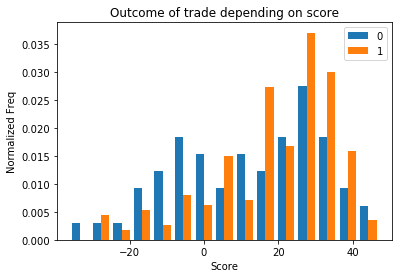

In [2088]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Score')
plt.ylabel('Normalized Freq')
plt.title('Outcome of trade depending on score')

### Making predictions and performance evaluation
We will use different cutoffs and make predictions using these using the test set

Let's create a new dataframe only with the columns we are interested in:

In [2089]:
scoreDF=contDF.iloc[:,[outcome_ix,37]]

In [2090]:
def predictOutcome(row, cutoff):
    pred=None
    if row['score'] >cutoff:
        pred=1
    else:
        pred=0
    return pred

In [2091]:
scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=10)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* Performance evaluation

In [2092]:
(tn, fp, fn, tp)=confusion_matrix(scoreDF[outcome_lab], scoreDF['predict']).ravel()
print("TP:"+str(tp))
print("TN:"+str(tn))
print("FN:"+str(fn))
print("FP:"+str(fp))

TP:155
TN:27
FN:50
FP:32


    * Precision

In [2093]:
print(tp/(tp+fp))

0.828877005348


* Recall

In [2094]:
print(tp/(tp+fn))

0.756097560976


### Cross-validation

In [2095]:
def cross_validate(cutoff,iterations):
    '''
    Function that will asses the sensitivity and specificity for differnt cutoff scores
    on different slices of the input dataframe
    
    Parameters
    ----------
    cutoff: int
            Cut off value used for predicting a trade as S or F
    iterations: int
                 Number of crossvalidation iterations
    '''
    precision_list=[]
    recall_list=[]
    tp_list=[]
    precission_list,recall_list,tn_list,fp_list,fn_list,tp_list = ([] for i in range(6))
    
    for i in range(0,iterations,1):
        #print("[WARN]: Iteration {0}".format(i))
        train, test = train_test_split(contDF,
                                       test_size=0.99)
        test['score']=test.apply(calculate_points, axis=1, attribs=attbs)
    
        scoreDF=test.iloc[:,[outcome_ix,37]]
        scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=cutoff)
        # assess performance
        (tn, fp, fn, tp)=confusion_matrix(scoreDF[outcome_lab], scoreDF['predict']).ravel()
        precision_list.append(tp/(tp+fp))
        recall_list.append(tp/(tp+fn))
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
    precission_array=np.array([precision_list])
    recall_array=np.array([recall_list])
    tn_array=np.array([tn_list])
    fp_array=np.array([fp_list])
    fn_array=np.array([fn_list])
    tp_array=np.array([tp_list])
    print("Precission: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(precission_array),np.std(precission_array),cutoff))
    print("Recall: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(recall_array),np.std(recall_array),cutoff))
    print("TN: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(tn_array),np.std(tn_array),cutoff))
    print("FP: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(fp_array),np.std(fp_array),cutoff))
    print("FN: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(fn_array),np.std(fn_array),cutoff))
    print("TP: AGV: {0},STD:{1},CUTOFF:{2}".format(np.average(tp_array),np.std(tp_array),cutoff))

Now, let's iterate a number of times (1000 in this case) on different cutoffs

In [ ]:
for i in range(-10,20,1):
    cross_validate(i,1)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Precission: AGV: 0.7842323651452282,STD:0.0,CUTOFF:-10
Recall: AGV: 0.9310344827586207,STD:0.0,CUTOFF:-10
TN: AGV: 7.0,STD:0.0,CUTOFF:-10
FP: AGV: 52.0,STD:0.0,CUTOFF:-10
FN: AGV: 14.0,STD:0.0,CUTOFF:-10
TP: AGV: 189.0,STD:0.0,CUTOFF:-10
Precission: AGV: 0.8008474576271186,STD:0.0,CUTOFF:-9
Recall: AGV: 0.9219512195121952,STD:0.0,CUTOFF:-9
TN: AGV: 10.0,STD:0.0,CUTOFF:-9
FP: AGV: 47.0,STD:0.0,CUTOFF:-9
FN: AGV: 16.0,STD:0.0,CUTOFF:-9
TP: AGV: 189.0,STD:0.0,CUTOFF:-9
Precission: AGV: 0.7982832618025751,STD:0.0,CUTOFF:-8
Recall: AGV: 0.916256157635468,STD:0.0,CUTOFF:-8
TN: AGV: 12.0,STD:0.0,CUTOFF:-8
FP: AGV: 47.0,STD:0.0,CUTOFF:-8
FN: AGV: 17.0,STD:0.0,CUTOFF:-8
TP: AGV: 186.0,STD:0.0,CUTOFF:-8
Precission: AGV: 0.7991266375545851,STD:0.0,CUTOFF:-7
Recall: AGV: 0.9014778325123153,STD:0.0,CUTOFF:-7
TN: AGV: 13.0,STD:0.0,CUTOFF:-7
FP: AGV: 46.0,STD:0.0,CUTOFF:-7
FN: AGV: 20.0,STD:0.0,CUTOFF:-7
TP: AGV: 183.0,STD:0.0,CUTOFF:-7
Precission: AGV: 0.7973568281938326,STD:0.0,CUTOFF:-6
Recall: AG

### Using a Binary classifier
First, let's prepare the data by separating the data into labels (dependent variable, which is the variable we try to predict) and features (the independent variables that are going to be used for the model)

In [ ]:
labels=contDF['ext_outcome']
features=contDF.drop(["ext_outcome","outcome"],axis=1)

We need also to remove some features that will be not accepted by the classifier or are not useful

In [ ]:
features=features.drop(["id","start","timeframe","entry","retraced","last time","target","bounce length","space interswings"],axis=1)

Now, let's split our data into training and test sets. In this case, the test_size=0.33

In [ ]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

As the counts for each outcome category are unbalanced, I will oversample using SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE

train_resampled, trainlabels_resampled = SMOTE().fit_sample(train,train_labels)

Let's check the balanced counts:

In [ ]:
from collections import Counter

print(sorted(Counter(trainlabels_resampled).items()))

#### naive_bayes

Building and Evaluating the Model for the non oversampled train dataset

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

In [ ]:
# Make predictions
preds = gnb.predict(test)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
# Train our classifier
model = gnb.fit(train_resampled,  trainlabels_resampled)

# Make predictions
preds = gnb.predict(test)

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

**Conclusion** It is slightly better using oversampling

#### Using SGDClassifier
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train,train_labels)

In [ ]:
preds=sgd_clf.predict(test)

In [ ]:
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train_resampled,trainlabels_resampled)
preds=sgd_clf.predict(test)
print(accuracy_score(test_labels, preds))

#### Using Logistic Regression  
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train, train_labels)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [ ]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [ ]:
score = logisticRegr.score(test, test_labels)
print(score)

In order to visualize the correctness of our predictions, we can also create a confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels, predictions)
print(cm)

The matrix above can be embellished by using seaborn:

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Now, let's try with the oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train_resampled,trainlabels_resampled)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [119]:
predictions = logisticRegr.predict(test)

NameError: name 'logisticRegr' is not defined

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [120]:
score = logisticRegr.score(test, test_labels)
print(score)

NameError: name 'logisticRegr' is not defined

**Conclusion:** It is worst to oversample in terms of score

* Examining the influence of each predictor on the outcome

In [121]:
stds=np.std(train, 0)

print(stds.values*m.coef_)

NameError: name 'm' is not defined

In [ ]:
keys=list(train.columns)
values_10=list(stds.values*m.coef_)[0]*10

coefficients=dict(zip(keys,values_10))
print(coefficients)

**Conclusions:**  
* Relevant  
{{train.columns[0]}} (negative)  
{{train.columns[1]}} (negative)  
{{train.columns[2]}} (positive)  
{{train.columns[4]}} (negative)  
{{train.columns[5]}} (positive)  
{{train.columns[7]}} (positive)  
{{train.columns[8]}} (negative)  
{{train.columns[9]}} (negative)  
{{train.columns[10]}} (positive)  
{{train.columns[11]}} (negative)  
{{train.columns[12]}} (positive)  
{{train.columns[13]}} (negative)  
{{train.columns[14]}} (positive)  

* Irrelevant  
{{train.columns[3]}}  
{{train.columns[6]}}  
{{train.columns[15]}}